In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from is3.baselines.wavelet.wavelet_script import *

from is3.metrics import compute_si_sdr

In [52]:
sr = 44100

In [ ]:
DATA = os.environ['DATA_DIR']

dataset_path = os.path.join(
    DATA,
    "ImpulseSeparationScenes_reverb" # or to whatever name you have given to the dataset folder
)

metadata_path = os.path.join(
    dataset_path,
    "metadata.csv"
)

pdf_metadata = pd.read_csv(metadata_path)

In [54]:
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio

overall_max = np.max(
    pdf_metadata['dba_normalization_gain'] /
    pdf_metadata['normalization_gain'])


def read_scene(scene_index, subset='test', dataset='original'):
  scene = pdf_metadata[(pdf_metadata['scene_index'] == scene_index) & (
      pdf_metadata['subset'] == subset)]

  print(os.path.join(dataset_path, scene['background_audio_path'].values[0]))

  bkg, sr = librosa.load(
      os.path.join(dataset_path, scene['background_audio_path'].values[0]),
      sr=None)

  impulse, sr = librosa.load(
      os.path.join(dataset_path, scene['impulse_audio_path'].values[0]),
      sr=None)

  mix, sr = librosa.load(
      os.path.join(dataset_path, scene['mixture_audio_path'].values[0]),
      sr=None)

  norm_gain = scene['normalization_gain'].values[0]

  if dataset == "random":
    gain = np.random.uniform(1e-5, 0.999)
  else:
    gain = scene['dba_normalization_gain'].values[0] / norm_gain
    gain /= overall_max

  bkg *= gain
  impulse *= gain
  mix *= gain

  fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True, sharey=True)

  axes[0].plot(bkg)
  axes[0].set_title('Background Audio')
  axes[0].grid(True)

  axes[1].plot(impulse)
  axes[1].set_title('Impulse Audio')
  axes[1].grid(True)

  axes[2].plot(mix)
  axes[2].set_title('Mixture Audio')
  axes[2].grid(True)

  plt.tight_layout()
  plt.show()

  print("Background")
  display(
      Audio(
          bkg /
          gain,
          rate=sr,
          normalize=False))
  print("Impulses")
  display(
      Audio(
          impulse /
          gain,
          rate=sr,
          normalize=False))
  print("Mix")
  display(
      Audio(
          mix /
          gain,
          rate=sr,
          normalize=False))

  return bkg, impulse, mix, gain, norm_gain

/home/admin/mnt/tsi/audiosig/audible/rendering/datasets/impulsive_sound_rejection/ImpulseSeparationScenes_reverb/audio/test/000/background_10.wav


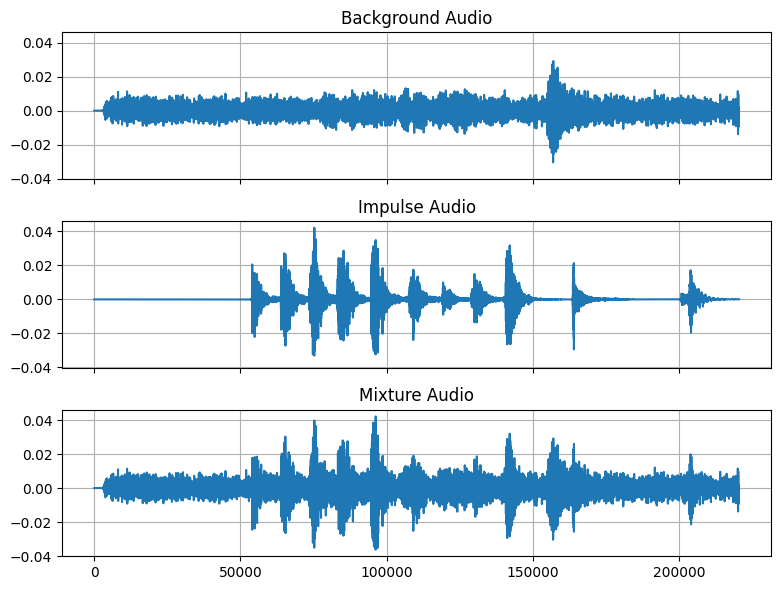

Background


Impulses


Mix


In [55]:
bkg, impulse, mix, gain, norm_gain = read_scene(
    scene_index=10, subset="test", dataset="random")

In [56]:
baseline = WaveletBaseline(
    wavelet="db",
    level=13,
    ks=2.,
    ks_impulse=6.,
    kc=1.,
    kernel_size=1025,
    sr=sr,
)

In [57]:
mix.shape

(220500,)

In [58]:
bkg_pred, imp_pred = baseline.forward(mix)

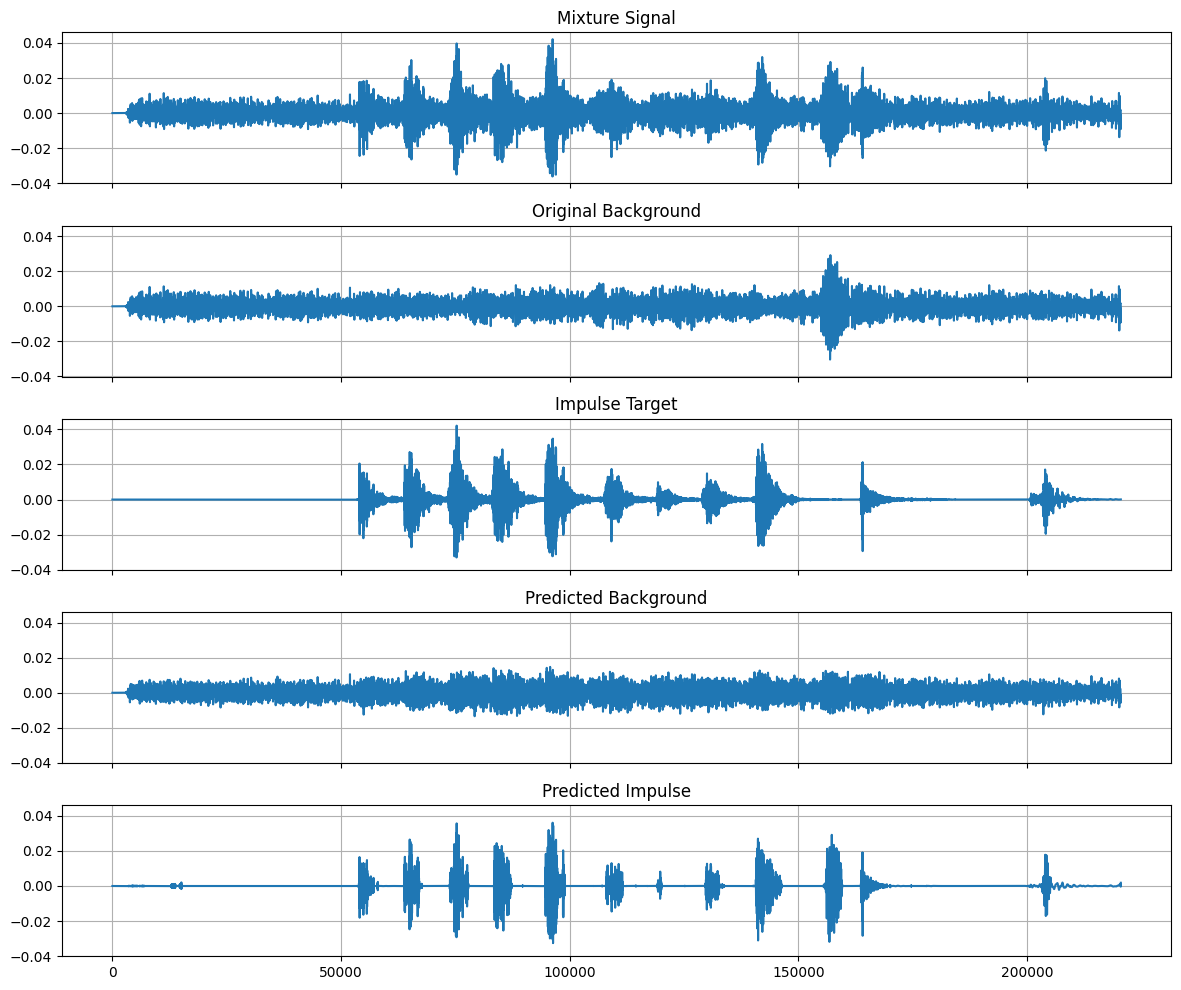

In [59]:
fig, axes = plt.subplots(5, 1, figsize=(12, 10), sharex=True, sharey=True)

axes[0].plot(mix)
axes[0].set_title('Mixture Signal')
axes[0].grid(True)

axes[1].plot(bkg)
axes[1].set_title('Original Background')
axes[1].grid(True)

axes[2].plot(impulse)
axes[2].set_title('Impulse Target')
axes[2].grid(True)

axes[3].plot(bkg_pred)
axes[3].set_title('Predicted Background')
axes[3].grid(True)

axes[4].plot(imp_pred)
axes[4].set_title('Predicted Impulse')
axes[4].grid(True)

plt.tight_layout()
plt.show()

In [60]:
from IPython.display import Audio

gain = np.maximum(np.max(np.abs(imp_pred)), np.max(np.abs(mix)))

print("Mixture")
display(Audio(mix / gain, rate=sr, normalize=False))
print("Original Background")
display(Audio(bkg / gain, rate=sr, normalize=False))
print("Predicted Background")
display(Audio(bkg_pred / gain, rate=sr, normalize=False))
print("Predicted Impulse")
display(Audio(imp_pred / gain, rate=sr, normalize=False))
print("Predicted Mix")
display(Audio((bkg_pred + imp_pred) / gain, rate=sr, normalize=True))

Mixture


Original Background


Predicted Background


Predicted Impulse


Predicted Mix


In [61]:
import torch

si_sdr = compute_si_sdr(
    estimated_signal=torch.tensor(bkg_pred).reshape(1, -1),
    reference_signal=torch.tensor(bkg).reshape(1, -1),
    scaling=True,
    remove_silences=False
)

print(si_sdr)

tensor([3.8550])


In [63]:
si_sdr = compute_si_sdr(
    estimated_signal=torch.tensor(imp_pred).reshape(1, -1),
    reference_signal=torch.tensor(impulse).reshape(1, -1),
    scaling=True,
    remove_silences=True
)

print(si_sdr)

tensor([1.3501])
